In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ECONOMIC DATA ANALYSIS WITH PANDAS

## Installing the fredapi

In [91]:
!pip install fredapi > /dev/null

## Importing the required libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

# fred_key = 'api_key'

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
fred_key = user_secrets.get_secret("fred_api")
# secret_value_0 = user_secrets.get_secret("fred_api")
# print(f"FRED API Key: {fred_key} (Length: {len(fred_key)})")

## Creating Fred Object

In [93]:
 fred = Fred(api_key=fred_key)

## Searching Economic Data

In [94]:
sp_search = fred.search('S&P', order_by='popularity')

In [95]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-08-14,2024-08-14,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2024-08-12,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-08-13 08:51:14-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-08-14,2024-08-14,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2024-05-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2024-07-30 08:11:01-05:00,88,"For more information regarding the index, plea..."
SP500,SP500,2024-08-14,2024-08-14,S&P 500,2014-08-14,2024-08-13,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-08-13 19:17:26-05:00,83,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2024-08-14,2024-08-14,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,83,Household data are collected as of March. As ...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-08-14,2024-08-14,ICE BofA US High Yield Index Effective Yield,1996-12-31,2024-08-12,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-08-13 08:51:17-05:00,82,This data represents the effective yield of th...


## Pulling Raw Data and Plot

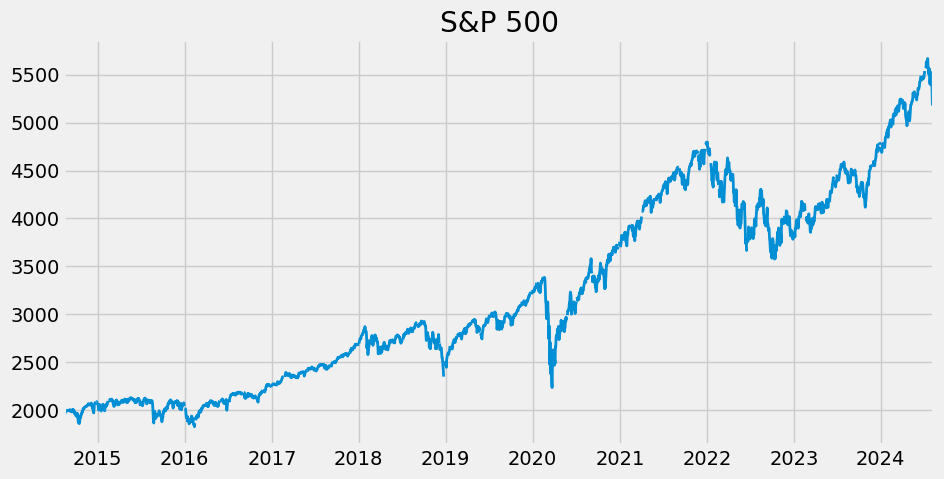

In [96]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

## Pulling and Joining Multiple Data Series

In [97]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [98]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [99]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [100]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [101]:
# Plot States Unemployment Rate
px.line(uemp_states)

## Pull May 2020 Unemployment Rate Per State

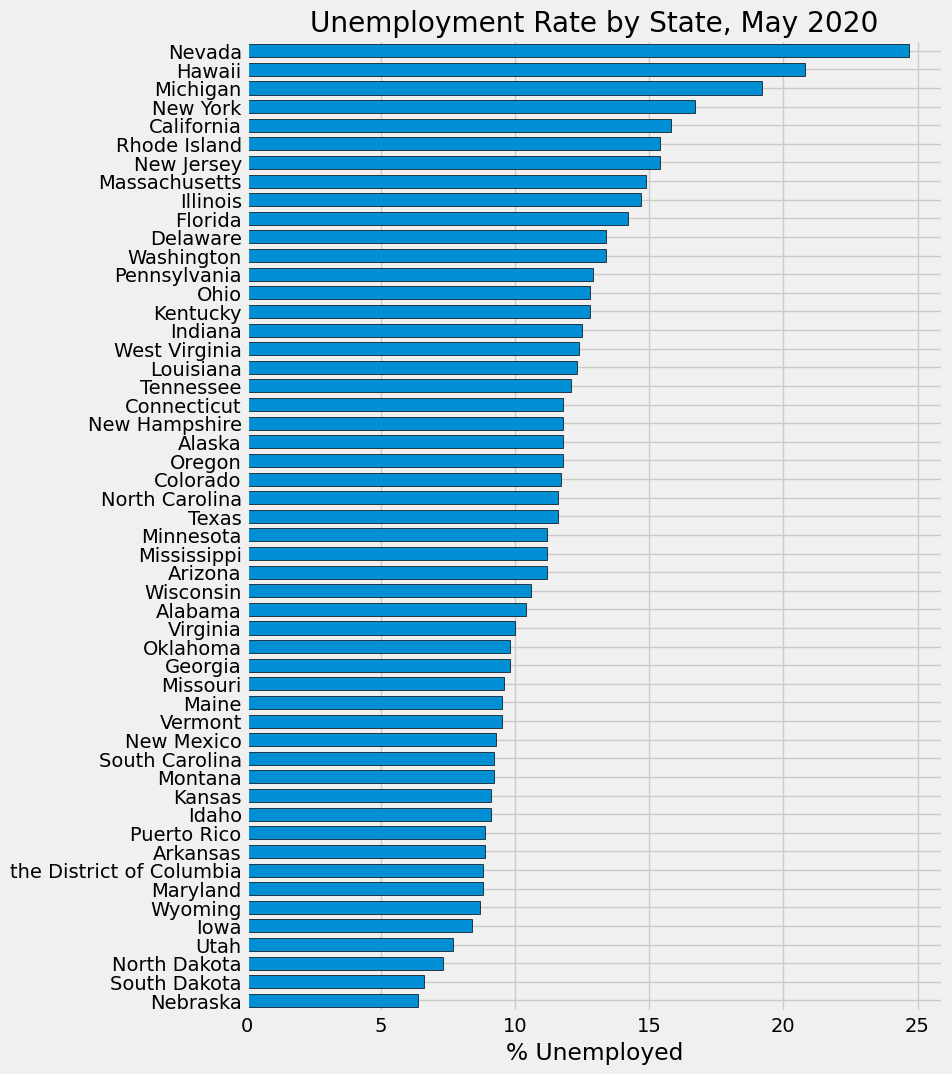

In [102]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

## Pull Participation Rate

In [103]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [104]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

## Plot Unemployment vs Participation for each state!

In [105]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

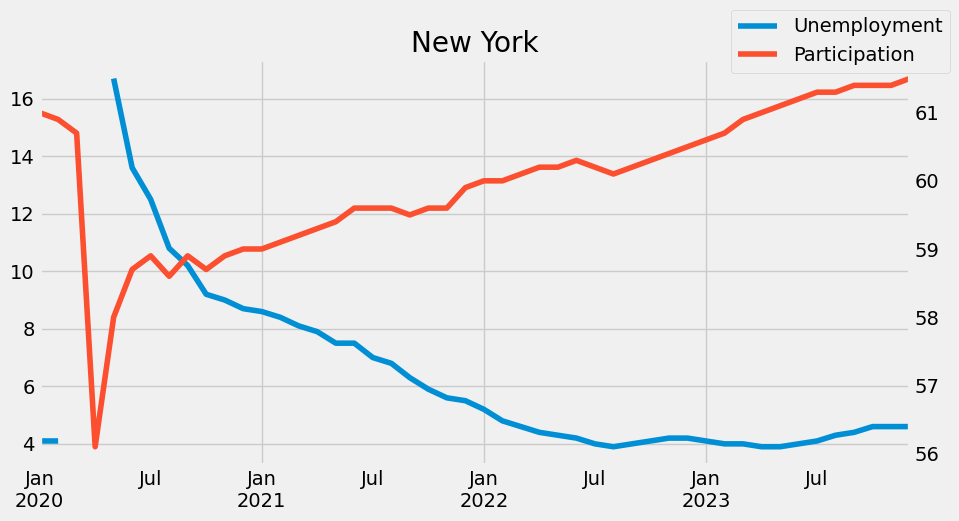

In [106]:
# For a specific state
state = 'New York'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2024')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2024')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()

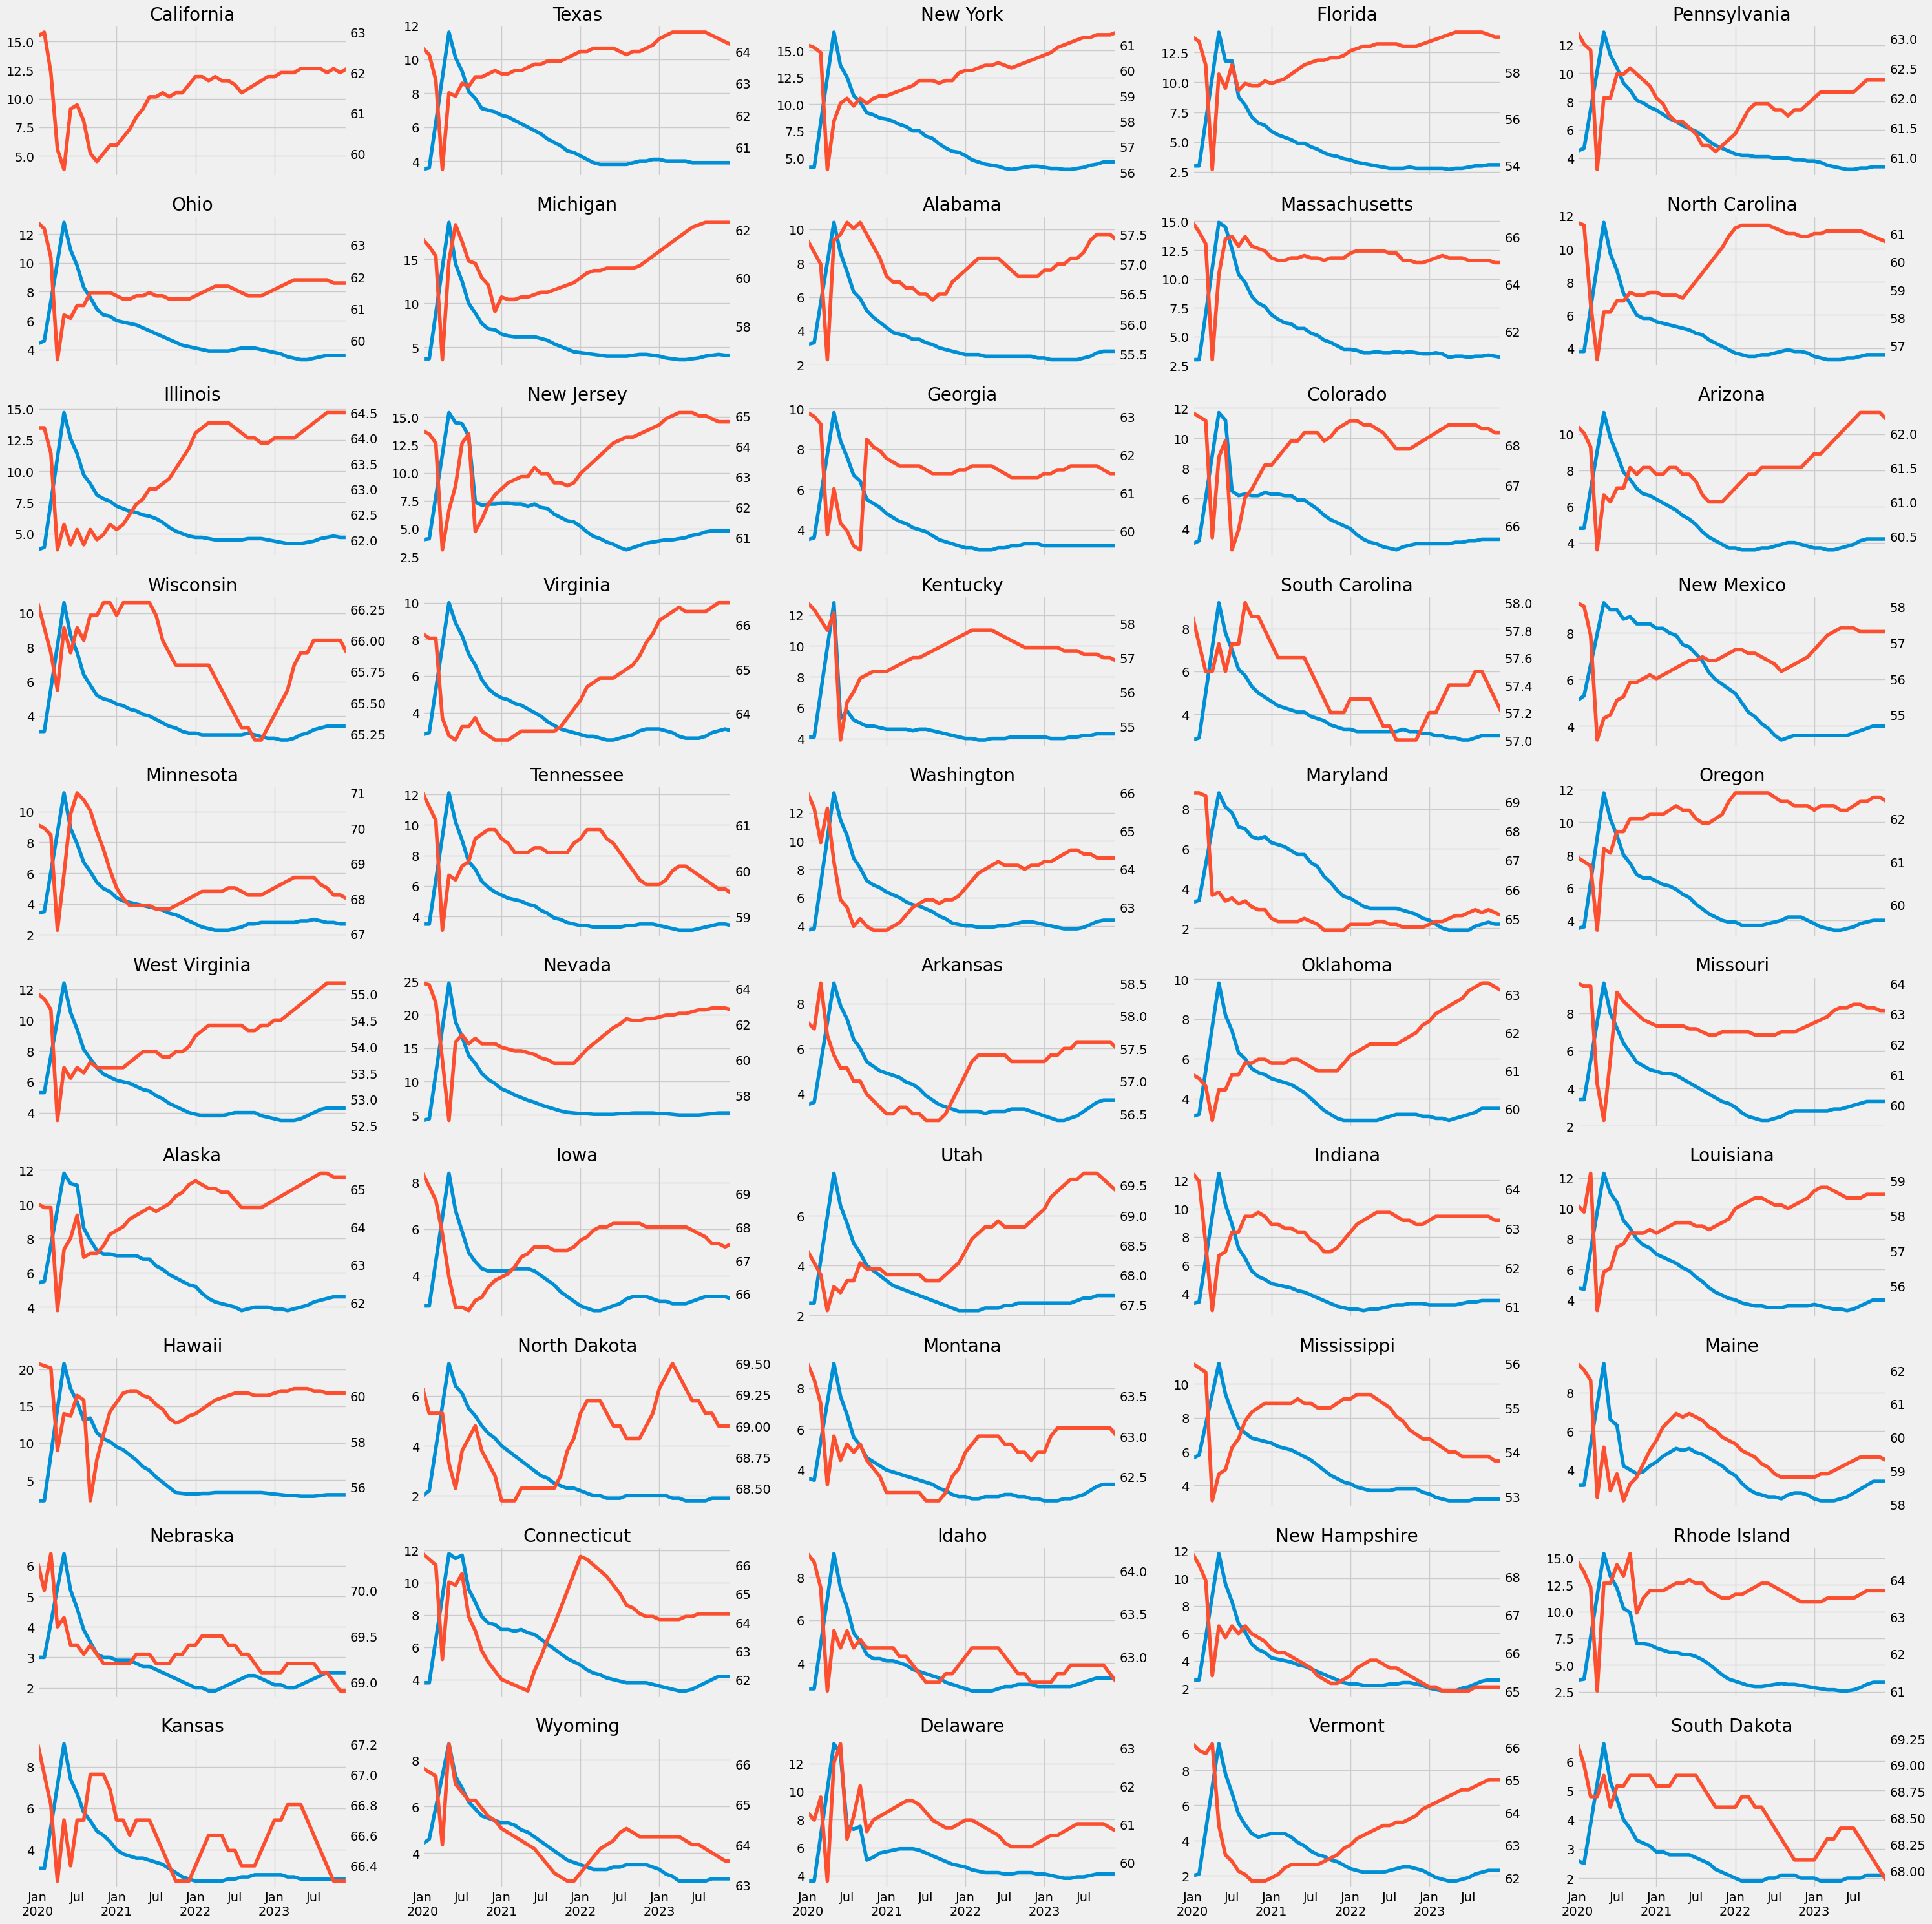

In [107]:
# For all states
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()